In [1]:
import os
import random
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

In [2]:
torch.cuda.is_available()

True

In [3]:
os.getcwd()

'/home/user/krishnanm0/CudaLab24'

## Dataset

In [4]:

lfw_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to fit MobileNetV3
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

lfw_dataset = datasets.LFWPeople(root='/home/user/krishnanm0/data', split='train', transform=lfw_transform, download=False)

lfw_train, lfw_val = torch.utils.data.random_split(lfw_dataset, [8500, 1025])

lfw_test = datasets.LFWPeople(root='/home/user/krishnanm0/data', split='test', transform=lfw_transform)



In [5]:
class TripletDataset:
    """
    Dataset class from which we sample random triplets
    """
    def __init__(self, dataset):
        """ Dataset initializer """
        self.dataset = dataset
        self.labels = np.array([label for _, label in dataset])
        self.label_to_indices = {label: np.where(self.labels == label)[0] for label in np.unique(self.labels)}
        self.all_indices = np.arange(len(dataset))
    
    def __len__(self):
        """ Returning number of anchors """
        return len(self.dataset)

    def __getitem__(self, index):
        """ 
        Sampling a triplet for the dataset. Index `index` corresponds to anchor 
        """
        anchor_img, anchor_lbl = self.dataset[index]

        # Positive sample selection
        positive_indices = self.label_to_indices[anchor_lbl]
        if len(positive_indices) > 1:
            positive_index = index
            while positive_index == index:
                positive_index = random.choice(positive_indices)
        else:
            # Choose a new anchor index until a different positive is found
            while True:
                new_anchor_index = random.choice(range(len(self.dataset)))
                new_anchor_img, new_anchor_lbl = self.dataset[new_anchor_index]
                positive_indices = self.label_to_indices[new_anchor_lbl]
                if len(positive_indices) > 1:
                    positive_index = new_anchor_index
                    while positive_index == new_anchor_index:
                        positive_index = random.choice(positive_indices)
                    anchor_img, anchor_lbl = new_anchor_img, new_anchor_lbl
                    break
        pos_img, pos_lbl = self.dataset[positive_index]
        
        # Negative sample selection
        negative_label = anchor_lbl
        while negative_label == anchor_lbl:
            negative_label = random.choice(list(self.label_to_indices.keys()))
        negative_index = random.choice(self.label_to_indices[negative_label])
        neg_img, neg_lbl = self.dataset[negative_index]
        
        return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)
    
class SemiHardTripletDataset(TripletDataset):
    def __init__(self, dataset, model, margin=0.2):
        super().__init__(dataset)
        self.model = model
        self.margin = margin
    
    def __getitem__(self, i):
        anchor_img, anchor_lbl = self.dataset[i]

        pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
        pos_id = random.choice(pos_ids).item()
        pos_img, pos_lbl = self.dataset[pos_id]

        neg_ids = self.arange[torch.where(self.labels != anchor_lbl)]
        anchor_emb = self.model.forward_one(anchor_img.unsqueeze(0).to(self.model.device)).detach().cpu().numpy()
        neg_embs = [self.model.forward_one(self.dataset[n][0].unsqueeze(0).to(self.model.device)).detach().cpu().numpy() for n in neg_ids]

        d_ap = np.linalg.norm(anchor_emb - pos_img.numpy())
        neg_distances = [np.linalg.norm(anchor_emb - neg_emb) for neg_emb in neg_embs]
        
        semi_hard_negatives = [neg_ids[i] for i, d_an in enumerate(neg_distances) if d_an > d_ap and d_an < d_ap + self.margin]
        if semi_hard_negatives:
            neg_id = random.choice(semi_hard_negatives)
        else:
            neg_id = random.choice(neg_ids)

        neg_img, neg_lbl = self.dataset[neg_id]
        return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)


In [6]:
train_dataset = TripletDataset(lfw_train)
val_dataset = TripletDataset(lfw_val)
test_dataset = TripletDataset(lfw_test)

In [7]:
(anchor, positive, negative), _ = val_dataset[1]
anchor.shape

torch.Size([3, 224, 224])

In [8]:
def denormalize(tensor, mean =  [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    """
    Denormalize a tensor image with mean and std.

    Parameters:
    - tensor (torch.Tensor): Normalized image tensor.
    - mean (list or tuple): Mean values used for normalization.
    - std (list or tuple): Standard deviation values used for normalization.

    Returns:
    - torch.Tensor: Denormalized image tensor.
    """
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std)

    mean = mean.view(3, 1, 1)
    std = std.view(3, 1, 1)
    
    tensor = tensor * std + mean
    return tensor

Epoch 17 : Train Iter 2268: Loss=0.0):   2%|█▋                                                                                                   | 2269/132812.5 [14:56<14:19:19,  2.53it/s]


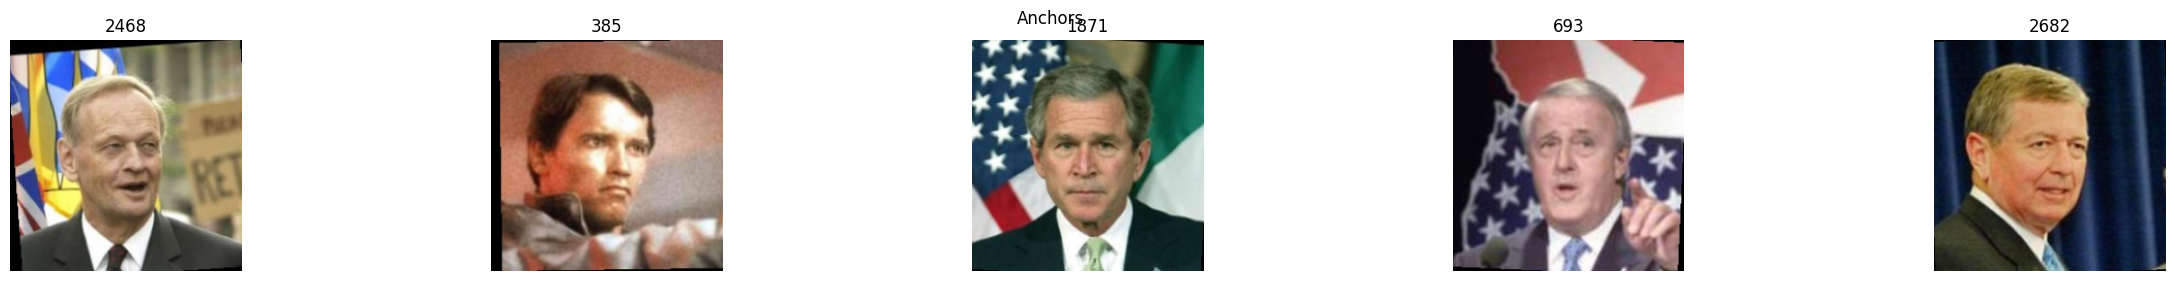

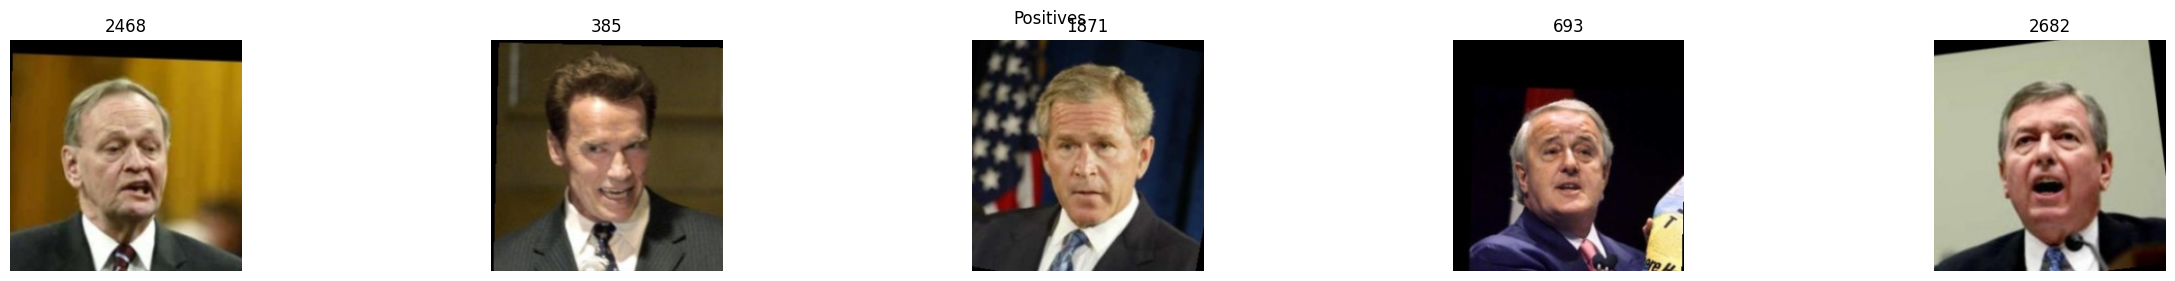

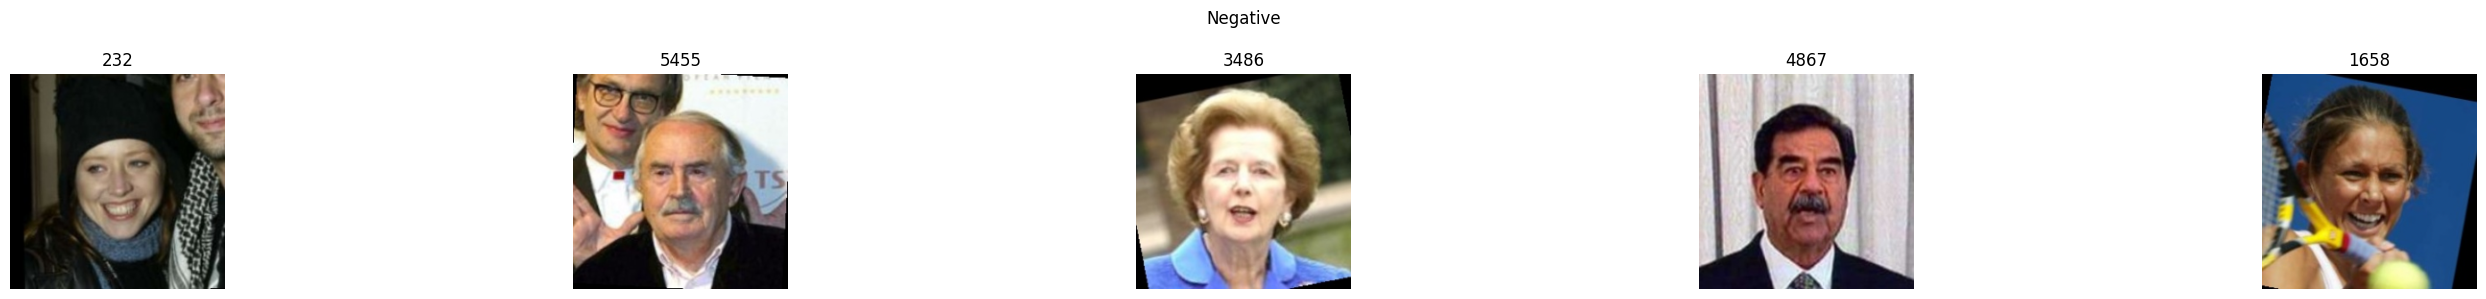

In [36]:
fig_anchors, anchors = plt.subplots(1, 5, figsize=(30,3))
fig_pos, positives = plt.subplots(1, 5, figsize=(30,3))
fig_neg, negatives = plt.subplots(1, 5, figsize=(30,3))
for i in range(5):
    (anchor, positive, negative), (labela, labelp , labeln) = val_dataset[i]
    anchor = denormalize(anchor)
    positive = denormalize(positive)
    negative = denormalize(negative)
    anchors[i].imshow(anchor.permute(1,2,0))
    anchors[i].set_title(labela)
    anchors[i].axis("off")
    positives[i].imshow(positive.permute(1,2,0))
    positives[i].set_title(labelp)
    positives[i].axis("off")
    negatives[i].imshow(negative.permute(1,2,0))
    negatives[i].set_title(labeln)
    negatives[i].axis("off")
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negative")
plt.tight_layout()
plt.show()

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4, drop_last=True) 
valid_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=True, num_workers=4, drop_last=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4, drop_last=True) 

## Utils

In [59]:
# utils

def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def save_model(model, optimizer, epoch, stats, margin):
    """ Saving model checkpoint """
    
    if(not os.path.exists("checkpoints")):
        os.makedirs("checkpoints")
    savepath = f"checkpoints/checkpoint_epoch_{epoch}_margin_{margin}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath, map_location="cpu")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(train_loss, val_loss, start=0):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_train = smooth(train_loss, 31)
    ax[0].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("linear")
    ax[0].set_title("Training Progress (linear)")
    
    ax[1].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title("Training Progress (log)")

    smooth_val = smooth(val_loss, 31)
    N_ITERS = len(val_loss)
    ax[2].plot(np.arange(start, N_ITERS)+start, val_loss[start:], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[2].plot(np.arange(start, N_ITERS)+start, smooth_val[start:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Iteration")
    ax[2].set_ylabel("CE Loss")
    ax[2].set_yscale("log")
    ax[2].set_title(f"Valid Progress")

    return

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    # Create a colormap with enough colors
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    colormap = plt.get_cmap('tab20', num_classes)
    COLORS = [colormap(i) for i in range(num_classes)]
    
    legend = [f"Class {l}" for l in unique_labels] if legend is None else legend
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    for i, l in enumerate(unique_labels):
        idx = np.where(l == labels)
        ax.scatter(points[idx, 0], points[idx, 1], label=legend[i], c=[COLORS[i]])
    ax.legend(loc="best")


## Siamese Model

In [12]:
class NormLayer(nn.Module):
    """ Layer that computer embedding normalization """
    def __init__(self, l=2):
        """ Layer initializer """
        assert l in [1, 2]
        super().__init__()
        self.l = l
        return
    
    def forward(self, x):
        """ Normalizing embeddings x. The shape of x is (B,D) """
        x_normalized = x / torch.norm(x, p=self.l, dim=-1, keepdim=True)
        return x_normalized

In [13]:
class ConvBlock(nn.Module):
    """ Building block with 2 convolutions """
    
    def __init__(self, in_channels, out_channels, kernel_size):
        """ """
        super().__init__()
        padding = kernel_size // 2
        self.block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
    
    def forward(self, x):
        """ """
        y = self.block(x)
        return y

class TriNet(nn.Module):
    """ 
    Implementation of the TriNet model 
    """
    def __init__(self, emb_dim=128):
        """ Module initializer """
        super().__init__()
        
        # Load pre-trained MobileNetV3_small
        mobilenet = models.mobilenet_v3_small(pretrained=True)
        
        # Extract features from the backbone
        self.features = nn.Sequential(*list(mobilenet.children())[:-1])  # Everything except the classifier
        
        # Fully connected embedder
        self.fc = nn.Linear(mobilenet.classifier[0].in_features, emb_dim)
        
        # Normalization layer
        self.norm = NormLayer()
    
    def forward_one(self, x):
        """ Forwarding just one sample through the model """
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.norm(x)
        return x
    
    def forward(self, anchor, positive, negative):
        """ Forwarding a triplet """
        anchor_emb = self.forward_one(anchor)
        positive_emb = self.forward_one(positive)
        negative_emb = self.forward_one(negative)
        
        return anchor_emb, positive_emb, negative_emb



In [14]:
# Initialize the model
model = TriNet(emb_dim=128)
print(f"Model has {count_model_params(model)} parameters")
model

Model has 1000864 parameters


/home/user/krishnanm0/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/krishnanm0/anaconda3/envs/CudaLab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TriNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2dNormActiva

## Training

In [15]:
class TripletLoss(nn.Module):
    """ Implementation of the triplet loss function """
    def __init__(self, margin=0.2, reduce="mean"):
        """ Module initializer """
        assert reduce in ["mean", "sum"]
        super().__init__()
        self.margin = margin
        self.reduce = reduce
        return
        
    def forward(self, anchor, positive, negative):
        """ Computing pairwise distances and loss functions """
        # L2 distances
        d_ap = (anchor - positive).pow(2).sum(dim=-1)
        d_an = (anchor - negative).pow(2).sum(dim=-1)
        
        # triplet loss function
        loss = (d_ap - d_an + self.margin)
        loss = torch.maximum(loss, torch.zeros_like(loss))
        
        # averaging or summing      
        loss = torch.mean(loss) if(self.reduce == "mean") else torch.sum(loss)
      
        return loss

In [16]:
class Trainer:
    """
    Class for training and validating a siamese model
    """
    
    def __init__(self, model, criterion, train_loader, valid_loader, n_iters=1e4):
        """ Trainer initializer """
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.n_iters = int(n_iters)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.train_loss = []
        self.valid_loss = []
        return
    
    @torch.no_grad()
    def valid_step(self, val_iters=100):
        """ Some validation iterations """
        self.model.eval()
        cur_losses = []
        for i, ((anchors, positives, negatives),_) in enumerate(self.valid_loader):   
            # setting inputs to GPU
            anchors = anchors.to(self.device)
            positives = positives.to(self.device)
            negatives = negatives.to(self.device)
            
            # forward pass and triplet loss
            anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
            loss = self.criterion(anchor_emb, positive_emb, negative_emb)
            cur_losses.append(loss.item())
            
            if(i >= val_iters):
                break
    
        self.valid_loss += cur_losses
        self.model.train()
        
        return cur_losses
    
    def fit(self):
        """ Train/Validation loop """
    
        self.iter_ = 0
        progress_bar = tqdm(total=self.n_iters*(8500/64), initial=0)
        
        for i in range(self.n_iters):
            for (anchors, positives, negatives), _ in self.train_loader:     
                # setting inputs to GPU
                anchors = anchors.to(self.device)
                positives = positives.to(self.device)
                negatives = negatives.to(self.device)
                
                # forward pass and triplet loss
                anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
                loss = self.criterion(anchor_emb, positive_emb, negative_emb)
                self.train_loss.append(loss.item())
                
                # optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # updating progress bar
                progress_bar.set_description(f"Epoch {i} : Train Iter {self.iter_}: Loss={round(loss.item(),5)})")
                progress_bar.update(1)
                # doing some validation every once in a while
                if(self.iter_ % 250 == 0):
                    cur_losses = self.valid_step()
                    print(f"Valid loss @ iteration {self.iter_}: Loss={np.mean(cur_losses)}")
                
                self.iter_ = self.iter_+1 
                
        return

In [17]:
model = TriNet()
criterion = TripletLoss(margin=0.2)

In [18]:
trainer = Trainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=1000)

In [19]:
trainer.fit()

Epoch 0 : Train Iter 1: Loss=0.13957):   0%|                                                                                                        | 2/132812.5 [00:04<81:17:12,  2.20s/it]

Valid loss @ iteration 0: Loss=0.10120461229234934


Epoch 1 : Train Iter 251: Loss=0.01861):   0%|▏                                                                                                   | 252/132812.5 [00:37<33:21:10,  1.10it/s]

Valid loss @ iteration 250: Loss=0.03125085326610133


Epoch 3 : Train Iter 501: Loss=0.01785):   0%|▍                                                                                                   | 502/132812.5 [01:11<32:53:40,  1.12it/s]

Valid loss @ iteration 500: Loss=0.022437469917349517


Epoch 5 : Train Iter 751: Loss=0.00399):   1%|▌                                                                                                   | 752/132812.5 [01:45<34:03:35,  1.08it/s]

Valid loss @ iteration 750: Loss=0.020294833928346634


Epoch 7 : Train Iter 1001: Loss=0.0059):   1%|▋                                                                                                  | 1002/132812.5 [02:19<33:44:56,  1.08it/s]

Valid loss @ iteration 1000: Loss=0.01726829849940259


Epoch 9 : Train Iter 1251: Loss=0.00102):   1%|▉                                                                                                 | 1252/132812.5 [02:53<32:41:53,  1.12it/s]

Valid loss @ iteration 1250: Loss=0.017452117492211983


Epoch 11 : Train Iter 1501: Loss=0.00687):   1%|█                                                                                                | 1502/132812.5 [03:27<32:37:38,  1.12it/s]

Valid loss @ iteration 1500: Loss=0.025105703563895077


Epoch 13 : Train Iter 1751: Loss=0.0):   1%|█▎                                                                                                   | 1752/132812.5 [04:01<34:14:54,  1.06it/s]

Valid loss @ iteration 1750: Loss=0.020896152884233743


Epoch 15 : Train Iter 2001: Loss=0.0):   2%|█▌                                                                                                   | 2002/132812.5 [04:35<32:50:35,  1.11it/s]

Valid loss @ iteration 2000: Loss=0.029243098688311875


Epoch 17 : Train Iter 2251: Loss=0.0):   2%|█▋                                                                                                   | 2252/132812.5 [05:09<36:30:18,  1.01s/it]

Valid loss @ iteration 2250: Loss=0.02372846333310008


Epoch 17 : Train Iter 2268: Loss=0.0):   2%|█▋                                                                                                    | 2269/132812.5 [05:11<4:28:08,  8.11it/s]

KeyboardInterrupt: 

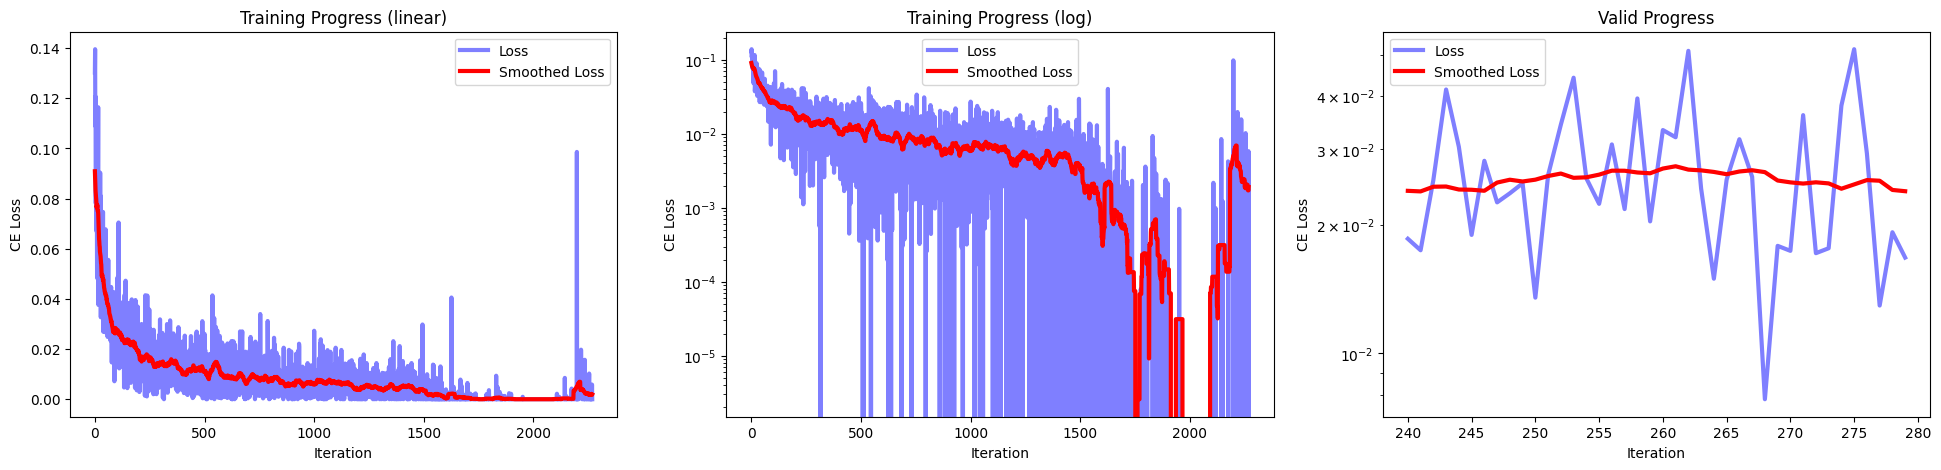

In [20]:
visualize_progress(trainer.train_loss, trainer.valid_loss, start=120)
plt.show()

In [21]:
stats = {
    "train_loss": trainer.train_loss,
    "valid_loss": trainer.valid_loss
}
save_model(trainer.model, trainer.optimizer, trainer.iter_, stats, margin=0.2)

### Loading a model trained for 10,000 iterations

In [ ]:
model, optimizer, epoch, stats = load_model(trainer.model, trainer.optimizer, savepath="checkpoints/checkpoint_epoch_2269.pth")
# model, optimizer, epoch, stats = load_model(trainer.model, trainer.optimizer, savepath="checkpoints/checkpoint_epoch_1000_margin_0.001.pth")
# model, optimizer, epoch, stats = load_model(trainer.model, trainer.optimizer, savepath="checkpoints/checkpoint_epoch_1000_margin_0.2.pth")
# model, optimizer, epoch, stats = load_model(trainer.model, trainer.optimizer, savepath="checkpoints/checkpoint_epoch_1000_margin_0.5.pth")

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/checkpoint_epoch_10.pth'

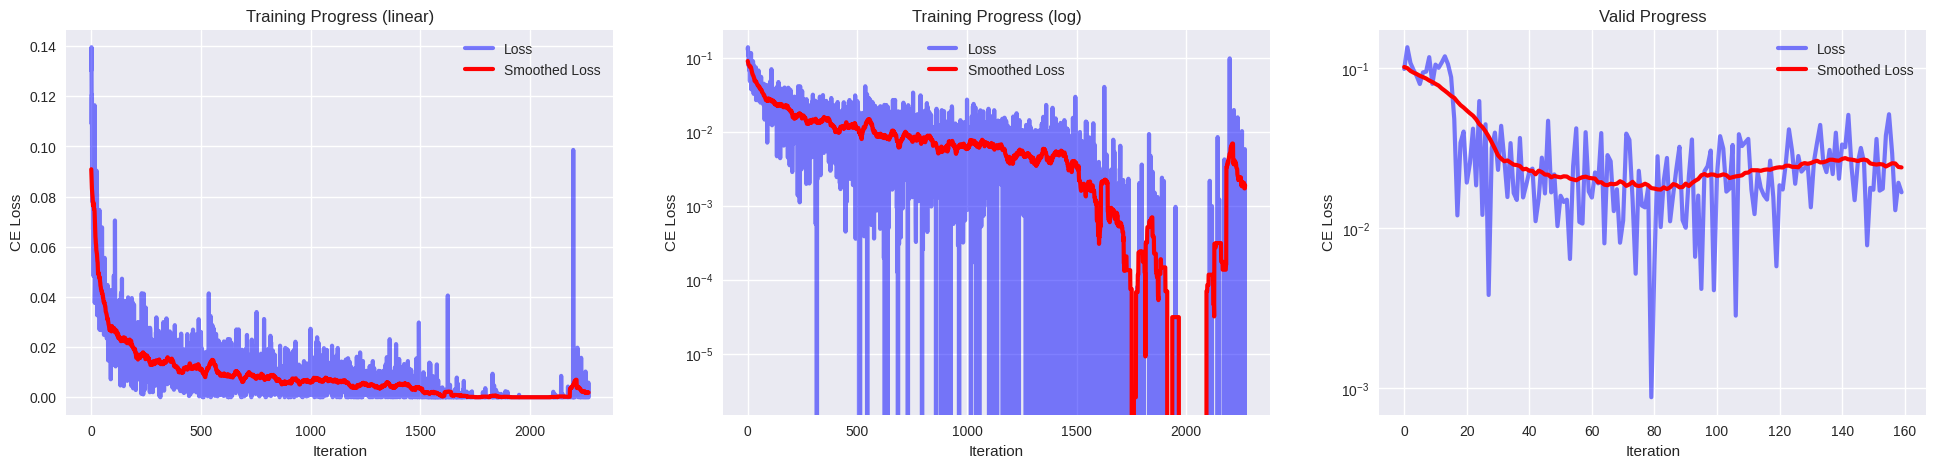

In [58]:
visualize_progress(stats["train_loss"], stats["valid_loss"], start=0)
plt.show()

## Visualizing Embeddings

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [24]:
# model = trainer.model
device = trainer.device
model = model.eval()

In [34]:
(img,_,_),(lbl,_,_) = next(iter(test_loader))
lbl[0]

tensor(1892)

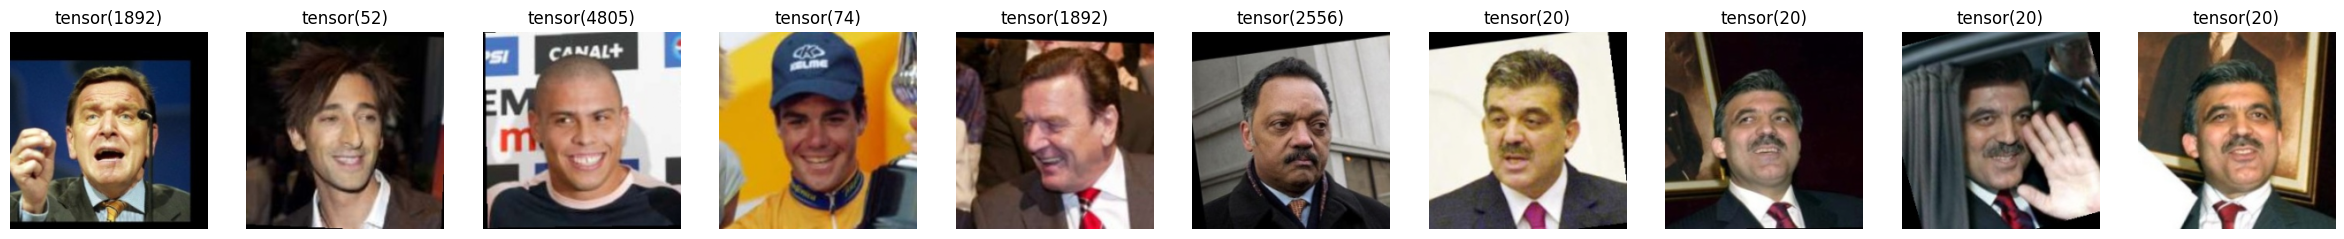

In [37]:
fig, ax = plt.subplots(1,10, figsize=(30,3))
for i in range(10):
    ax[i].imshow(denormalize(img[i]).permute(1,2,0))
    ax[i].set_title(lbl[i])
    ax[i].axis("off")
plt.show()

In [38]:
imgs_flat = []
embs = []
labels = []
with torch.no_grad():
    for (anchor, _, _), (lbl,_, _) in test_loader:
        anchor = anchor.to(device)
        anchor_emb = model.forward_one(anchor)
        
        labels.append(lbl)
        embs.append(anchor_emb.cpu())
        imgs_flat.append(anchor.cpu().flatten(1))

labels = np.concatenate(labels)
embs = np.concatenate(embs)
imgs_flat = np.concatenate(imgs_flat)

In [39]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_embs = PCA(n_components=2).fit_transform(embs)

In [43]:
test_dataset.dataset.labels_file

'peopleDevTest.txt'

#### Modified display projection function and code to show embeddings for faces with highest frequency

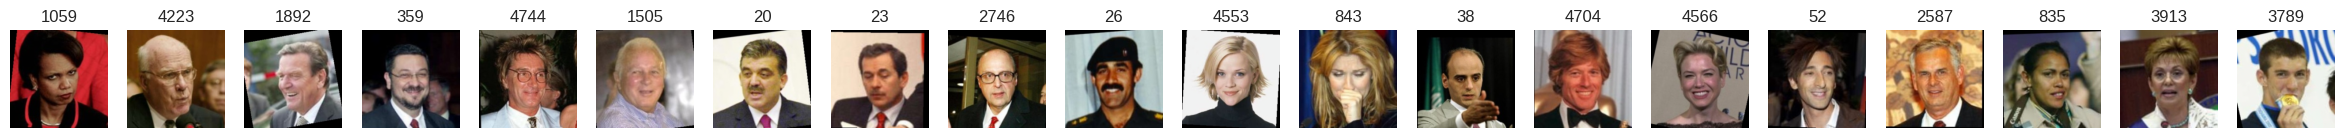

/tmp/ipykernel_286635/2927444155.py:66: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


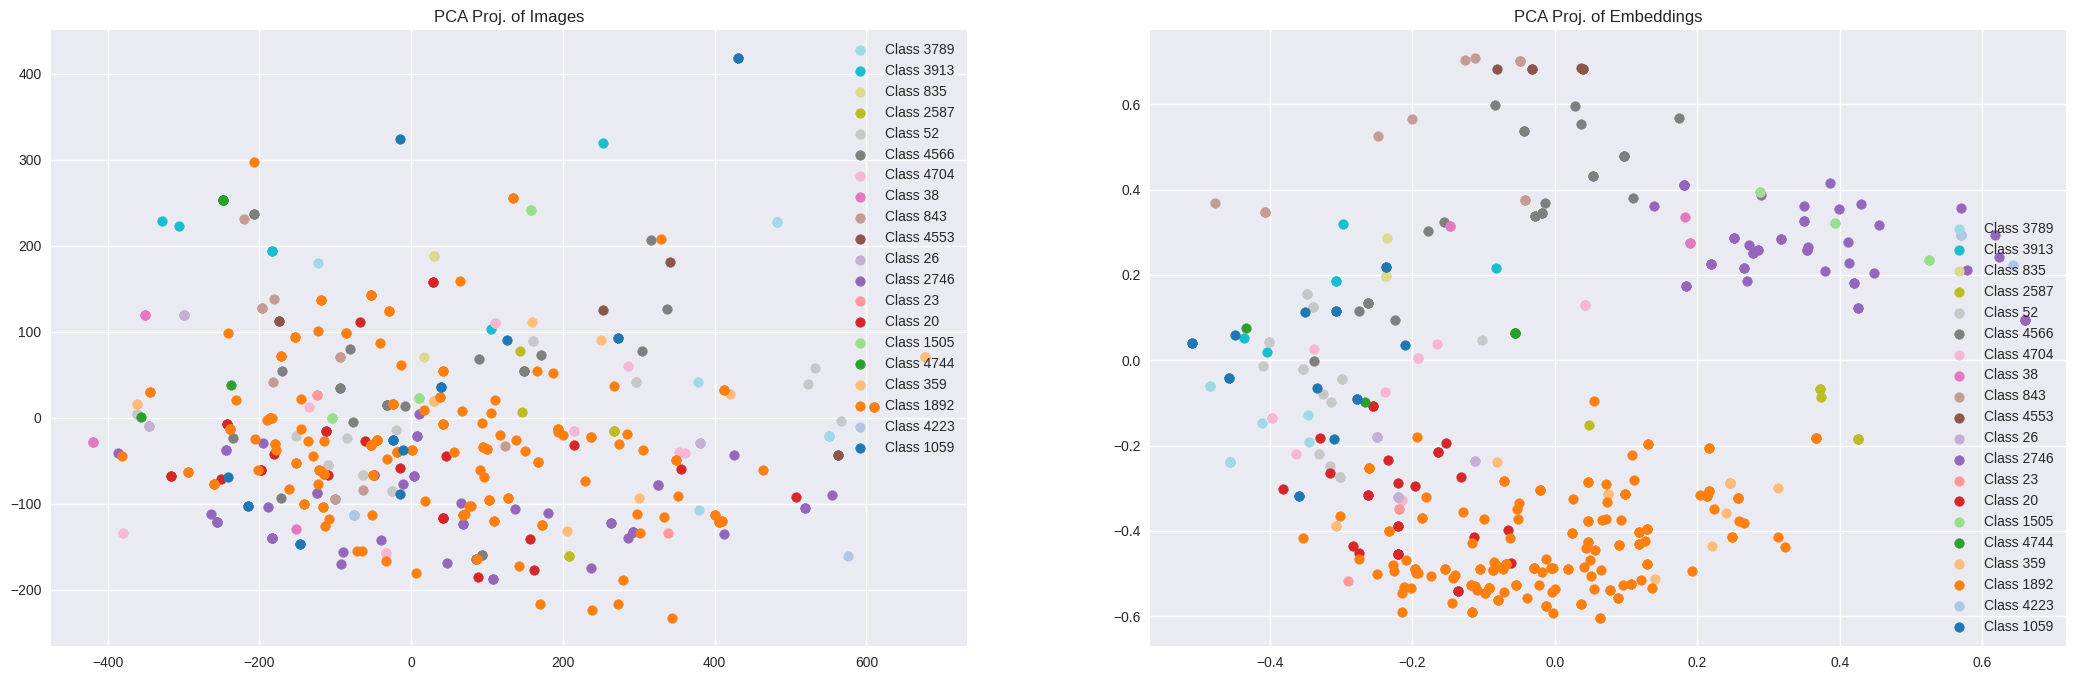

In [92]:
from collections import Counter

def display_projections(points, labels, ax=None, legend=None, N=20):
    """ Displaying low-dimensional data projections """
    
    unique_labels = np.array([label for label, count in Counter(labels).items()])
    num_classes = len(unique_labels[:N])
    colormap = plt.get_cmap('tab20', num_classes)
    COLORS = {label: colormap(i) for i, label in enumerate(unique_labels[:N])}
    
    if legend is None:
        legend = {label: f"Class {label}" for label in unique_labels[:N]}
    
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    for label in reversed(unique_labels[:N]):
        idx = np.where(labels == label)
        ax.scatter(points[idx, 0], points[idx, 1], label=legend[label], c=[COLORS[label]])
    ax.legend(loc="best")


# Choose the number of classes you want projected
#
N_proj = 20
#
#

imgs_flat = []
imgs = []
embs = []
labels = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for (anchor, _, _), (lbl, _, _) in test_loader:
        anchor = anchor.to(device)
        anchor_emb = model.forward_one(anchor)
        
        labels.append(lbl.numpy())
        embs.append(anchor_emb.cpu().numpy())
        imgs.append(anchor.cpu().numpy())
        imgs_flat.append(anchor.cpu().view(anchor.size(0), -1).numpy())

labels = np.concatenate(labels)
imgs = np.concatenate(imgs)
embs = np.concatenate(embs)
imgs_flat = np.concatenate(imgs_flat)
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_embs = PCA(n_components=2).fit_transform(embs)

label_counts = Counter(labels)

# Sort the labels by frequency of occurrence (from most to least)
sorted_labels = [label for label, count in label_counts.items()]

# Create the class names mapping based on sorted labels
class_names = {label: f"Class {label}" for label in sorted_labels}

fig, ax = plt.subplots(1, N_proj, figsize=(30, 3))

for i in range(N_proj):
    index = list(labels).index(sorted_labels[i])
    ax[i].imshow(denormalize(torch.tensor(imgs[index])).permute(1, 2, 0))
    ax[i].set_title(labels[index].item())
    ax[i].axis("off")
plt.show()


N = 5000
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2, figsize=(26, 8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=class_names,N=N_proj)
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_embs[:N], labels[:N], ax=ax[1], legend=class_names,N=N_proj)
ax[1].set_title("PCA Proj. of Embeddings")
plt.show()

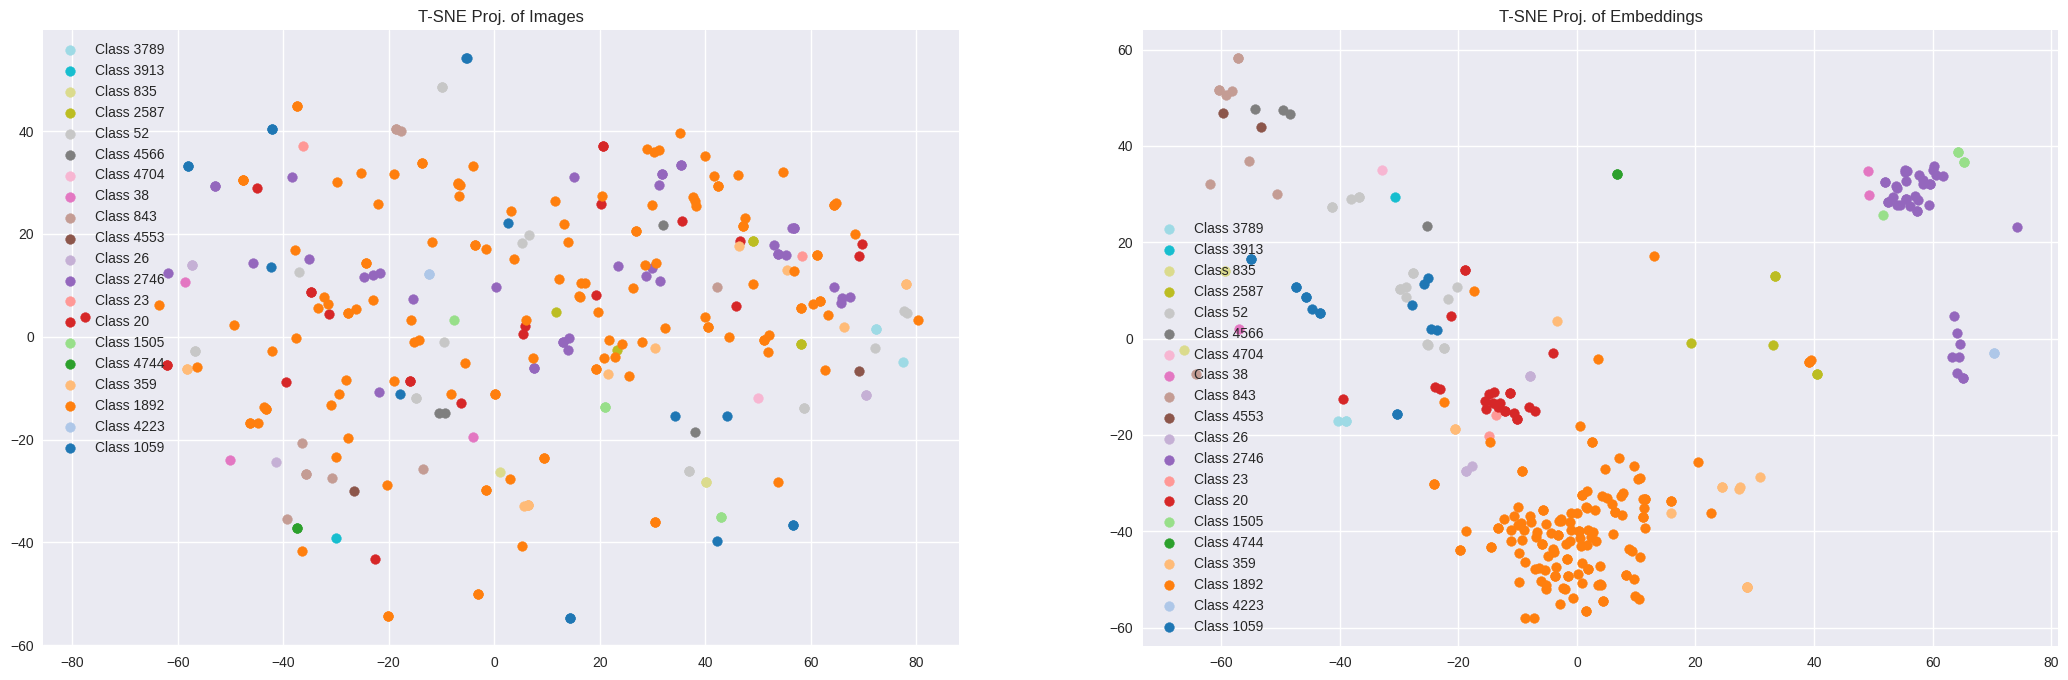

In [93]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_embs = TSNE(n_components=2).fit_transform(embs[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0], legend=class_names)
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_embs[:N], labels[:N], ax=ax[1], legend=class_names)
ax[1].set_title("T-SNE Proj. of Embeddings")
plt.show()